In [1]:
import pickle


# datasets/ntu60/Frames/ntu120_openpifpaf_0_6500.pkl
# datasets/ntu60/Frames/ntu60_hrnet.pkl

with open('datasets/ntu60/Frames/ntu60_hrnet.pkl', 'rb') as f:
    x = pickle.load(f)

with open('datasets/ntu60/Frames/ntu60_openpifpaf_HQ_fixed2.pkl', 'rb') as f:
    x_pifpaf = pickle.load(f)

In [18]:
""" import numpy as np
for item_pifpaf in x_pifpaf["annotations"]:
    item_pifpaf["keypoint"][:,:,:,0][item_pifpaf["keypoint"][:,:,:,0]<1] = np.mean(item_pifpaf["keypoint"][:,:,:,0])
    item_pifpaf["keypoint"][:,:,:,1][item_pifpaf["keypoint"][:,:,:,1]<1] = np.mean(item_pifpaf["keypoint"][:,:,:,1])


with open('datasets/ntu60/Frames/ntu60_openpifpaf_HQ_fixed.pkl', 'wb') as handle:
    pickle.dump(x_pifpaf, handle, protocol=pickle.HIGHEST_PROTOCOL) """

' import numpy as np\nfor item_pifpaf in x_pifpaf["annotations"]:\n    item_pifpaf["keypoint"][:,:,:,0][item_pifpaf["keypoint"][:,:,:,0]<1] = np.mean(item_pifpaf["keypoint"][:,:,:,0])\n    item_pifpaf["keypoint"][:,:,:,1][item_pifpaf["keypoint"][:,:,:,1]<1] = np.mean(item_pifpaf["keypoint"][:,:,:,1])\n\n\nwith open(\'datasets/ntu60/Frames/ntu60_openpifpaf_HQ_fixed.pkl\', \'wb\') as handle:\n    pickle.dump(x_pifpaf, handle, protocol=pickle.HIGHEST_PROTOCOL) '

In [3]:
""" import numpy as np

for item_hrnet, item_pifpaf in zip (x["annotations"], x_pifpaf["annotations"]):


    #item_pifpaf["keypoint"][item_pifpaf["keypoint"]<1] = item_pifpaf["img_shape"][0] //2
    #print (np.min(item_hrnet["keypoint"]), np.min(item_pifpaf["keypoint"]))
    diff_x = np.mean(item_pifpaf["keypoint"][:,:,:,0]) - np.mean(item_hrnet["keypoint"][:,:,:,0])
    diff_y = np.mean(item_pifpaf["keypoint"][:,:,:,1]) - np.mean(item_hrnet["keypoint"][:,:,:,1])

    item_pifpaf["keypoint"][:,:,:,0] -= diff_x
    item_pifpaf["keypoint"][:,:,:,1] -= diff_y
    
    diff = np.mean(item_pifpaf["keypoint"]) - np.mean(item_hrnet["keypoint"])

    if diff > 100:
        print (item_hrnet["keypoint"].shape, item_pifpaf["keypoint"].shape)
        print(item_hrnet["frame_dir"], item_pifpaf["frame_dir"])
        break

with open('datasets/ntu60/Frames/ntu60_openpifpaf_HQ_fixed2.pkl', 'wb') as handle:
    pickle.dump(x_pifpaf, handle, protocol=pickle.HIGHEST_PROTOCOL)  """

' import numpy as np\n\nfor item_hrnet, item_pifpaf in zip (x["annotations"], x_pifpaf["annotations"]):\n\n\n    #item_pifpaf["keypoint"][item_pifpaf["keypoint"]<1] = item_pifpaf["img_shape"][0] //2\n    #print (np.min(item_hrnet["keypoint"]), np.min(item_pifpaf["keypoint"]))\n    diff_x = np.mean(item_pifpaf["keypoint"][:,:,:,0]) - np.mean(item_hrnet["keypoint"][:,:,:,0])\n    diff_y = np.mean(item_pifpaf["keypoint"][:,:,:,1]) - np.mean(item_hrnet["keypoint"][:,:,:,1])\n\n    item_pifpaf["keypoint"][:,:,:,0] -= diff_x\n    item_pifpaf["keypoint"][:,:,:,1] -= diff_y\n    \n    diff = np.mean(item_pifpaf["keypoint"]) - np.mean(item_hrnet["keypoint"])\n\n    if diff > 100:\n        print (item_hrnet["keypoint"].shape, item_pifpaf["keypoint"].shape)\n        print(item_hrnet["frame_dir"], item_pifpaf["frame_dir"])\n        break\n\nwith open(\'datasets/ntu60/Frames/ntu60_openpifpaf_HQ_fixed2.pkl\', \'wb\') as handle:\n    pickle.dump(x_pifpaf, handle, protocol=pickle.HIGHEST_PROTOCOL)  '

In [2]:
import numpy as np

def resample(ori_len, target_len, replay=False, randomness=True):
    if replay:
        if ori_len > target_len:
            st = np.random.randint(ori_len-target_len)
            return range(st, st+target_len)  # Random clipping from sequence
        else:
            return np.array(range(target_len)) % ori_len  # Replay padding
    else:
        if randomness:
            even = np.linspace(0, ori_len, num=target_len, endpoint=False)
            if ori_len < target_len:
                low = np.floor(even)
                high = np.ceil(even)
                sel = np.random.randint(2, size=even.shape)
                result = np.sort(sel*low+(1-sel)*high)
            else:
                interval = even[1] - even[0]
                result = np.random.random(even.shape)*interval + even
            result = np.clip(result, a_min=0, a_max=ori_len-1).astype(np.uint32)
        else:
            result = np.linspace(0, ori_len, num=target_len, endpoint=False, dtype=int)
        return result

def fake(motion):
    if motion.shape[0]==1:                                  # Single person, make a fake zero person
        fake = np.zeros(motion.shape)
        motion = np.concatenate((motion, fake), axis=0)
    
    return motion

for item_hrnet, item_pifpaf in zip (x["annotations"], x_pifpaf["annotations"]):

    if item_pifpaf["keypoint"].shape[1] != item_hrnet["keypoint"].shape[1]:
        target_len = item_hrnet["keypoint"].shape[1]

        resample_id = resample(ori_len=item_pifpaf['total_frames'], target_len=target_len, randomness=False)
        #item_hrnet = resample(ori_len=item_hrnet['total_frames'], target_len=243, randomness=False)

        item_pifpaf["keypoint"] = item_pifpaf["keypoint"][:,resample_id]
        item_pifpaf["keypoint_score"] = item_pifpaf["keypoint_score"][:,resample_id]
        #item_hrnet["keypoint"] = item_hrnet["keypoint"][:,resample_id]


    if item_pifpaf["keypoint"].shape[0]==1 and item_hrnet["keypoint"].shape[0]==2:                                  # Single person, make a fake zero person
        item_pifpaf["keypoint"] =fake(item_pifpaf["keypoint"])
        item_pifpaf["keypoint_score"] =fake(item_pifpaf["keypoint_score"])

    #item_pifpaf["keypoint"] =fake(item_pifpaf["keypoint"])
    #item_hrnet["keypoint"] =fake(item_hrnet["keypoint"])

    item_pifpaf["keypoint"][:,:,:,0] -= (item_pifpaf["keypoint"][:,:,:,0] - item_hrnet["keypoint"][:,:,:,0])
    item_pifpaf["keypoint"][:,:,:,1] -= (item_pifpaf["keypoint"][:,:,:,1] - item_hrnet["keypoint"][:,:,:,1])


with open('datasets/ntu60/Frames/ntu60_openpifpaf_HQ_fixed5.pkl', 'wb') as handle:
    pickle.dump(x_pifpaf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
import numpy as np
from matplotlib import pyplot as plt

import copy


def resample(ori_len, target_len, replay=False, randomness=True):
    if replay:
        if ori_len > target_len:
            st = np.random.randint(ori_len-target_len)
            return range(st, st+target_len)  # Random clipping from sequence
        else:
            return np.array(range(target_len)) % ori_len  # Replay padding
    else:
        if randomness:
            even = np.linspace(0, ori_len, num=target_len, endpoint=False)
            if ori_len < target_len:
                low = np.floor(even)
                high = np.ceil(even)
                sel = np.random.randint(2, size=even.shape)
                result = np.sort(sel*low+(1-sel)*high)
            else:
                interval = even[1] - even[0]
                result = np.random.random(even.shape)*interval + even
            result = np.clip(result, a_min=0, a_max=ori_len-1).astype(np.uint32)
        else:
            result = np.linspace(0, ori_len, num=target_len, endpoint=False, dtype=int)
        return result


def make_cam(x, img_shape):
    '''
        Input: x (M x T x V x C)
               img_shape (height, width)
    '''

    h, w = img_shape
    if w >= h:
        x_cam = x / w * 2 - 1
    else:
        x_cam = x / h * 2 - 1
    return x_cam

def coco2h36m(x):
    '''
        Input: x (M x T x V x C)
        
        COCO: {0-nose 1-Leye 2-Reye 3-Lear 4Rear 5-Lsho 6-Rsho 7-Lelb 8-Relb 9-Lwri 10-Rwri 11-Lhip 12-Rhip 13-Lkne 14-Rkne 15-Lank 16-Rank}
        
        H36M:
        0: 'root',
        1: 'rhip',
        2: 'rkne',
        3: 'rank',
        4: 'lhip',
        5: 'lkne',
        6: 'lank',
        7: 'belly',
        8: 'neck',
        9: 'nose',
        10: 'head',
        11: 'lsho',
        12: 'lelb',
        13: 'lwri',
        14: 'rsho',
        15: 'relb',
        16: 'rwri'
    '''
    y = np.zeros(x.shape)
    y[:,:,0,:] = (x[:,:,11,:] + x[:,:,12,:]) * 0.5
    y[:,:,1,:] = x[:,:,12,:]
    y[:,:,2,:] = x[:,:,14,:]
    y[:,:,3,:] = x[:,:,16,:]
    y[:,:,4,:] = x[:,:,11,:]
    y[:,:,5,:] = x[:,:,13,:]
    y[:,:,6,:] = x[:,:,15,:]
    y[:,:,8,:] = (x[:,:,5,:] + x[:,:,6,:]) * 0.5
    y[:,:,7,:] = (y[:,:,0,:] + y[:,:,8,:]) * 0.5
    y[:,:,9,:] = x[:,:,0,:]
    y[:,:,10,:] = (x[:,:,1,:] + x[:,:,2,:]) * 0.5
    y[:,:,11,:] = x[:,:,5,:]
    y[:,:,12,:] = x[:,:,7,:]
    y[:,:,13,:] = x[:,:,9,:]
    y[:,:,14,:] = x[:,:,6,:]
    y[:,:,15,:] = x[:,:,8,:]
    y[:,:,16,:] = x[:,:,10,:]
    return y
    
def human_tracking(x):
    M, T = x.shape[:2]
    if M==1:
        return x
    else:
        diff0 = np.sum(np.linalg.norm(x[0,1:] - x[0,:-1], axis=-1), axis=-1)        # (T-1, V, C) -> (T-1)
        diff1 = np.sum(np.linalg.norm(x[0,1:] - x[1,:-1], axis=-1), axis=-1)
        x_new = np.zeros(x.shape)
        sel = np.cumsum(diff0 > diff1) % 2
        sel = sel[:,None,None]
        x_new[0][0] = x[0][0]
        x_new[1][0] = x[1][0]
        x_new[0,1:] = x[1,1:] * sel + x[0,1:] * (1-sel)
        x_new[1,1:] = x[0,1:] * sel + x[1,1:] * (1-sel)
        return x_new

def crop_scale(motion, scale_range=[1, 1]):
    '''
        Motion: [(M), T, 17, 3].
        Normalize to [-1, 1]
    '''
    result = copy.deepcopy(motion)
    valid_coords = motion[motion[..., 2]!=0][:,:2]
    if len(valid_coords) < 4:
        return np.zeros(motion.shape)
    
    #print("more than 4 valid motion records")

    xmin = min(valid_coords[:,0])
    xmax = max(valid_coords[:,0])
    ymin = min(valid_coords[:,1])
    ymax = max(valid_coords[:,1])

    #print("xmin, xmax, ymin, ymax: ", xmin, xmax, ymin, ymax)

    ratio = np.random.uniform(low=scale_range[0], high=scale_range[1], size=1)[0]
    scale = max(xmax-xmin, ymax-ymin) * ratio
    if scale==0:
        return np.zeros(motion.shape)
    
    #print("scale: ", scale)
    xs = (xmin+xmax-scale) / 2
    ys = (ymin+ymax-scale) / 2

    #print("xs, ys: ", xs, ys)

    #print("x mean 1: ", (motion[0,0,10, 0]))

    result[...,:2] = (motion[..., :2]- [xs,ys]) / scale

    #print("x mean 2: ", (result[0,0,10, 0]))

    #print("x print: ", ((result[0,0,10, 0])+1)/2)

    result[...,:2] = (result[..., :2] - 0.5) * 2

    result = np.clip(result, -1, 1)
    return result

def preprocess_data(ann, num_segments, is_train, noise = False, scale_range= [1,3]):

    sample = copy.deepcopy(ann)

    resample_id = resample(ori_len=sample['total_frames'], target_len=num_segments, randomness=is_train)

    #print("sample['keypoint'].shape 1: " ,sample['keypoint'].shape)
    # resample_id (48,)
    # Before make_cam (1, 103, 17, 2)
    sample['keypoint'] = sample['keypoint'].astype(np.float16)

    motion_cam = make_cam(x=sample['keypoint'], img_shape=sample['img_shape'])

    #motion_cam[:,:,:,0][motion_cam[:,:,:,0]<0] = np.mean(motion_cam[:,:,:,0])
    #motion_cam[:,:,:,1][motion_cam[:,:,:,1]<-0.99] = np.mean(motion_cam[:,:,:,1])
    # After make_cam (1, 103, 17, 2)

    if noise:
        sigma = 0.003
        _, T, V, M = motion_cam.shape
        noise = np.random.normal(0, sigma , (T, V, M))
        motion_cam[:,:,:,:] += noise
        motion_cam = np.clip(motion_cam, -1, 1)
    

    

    motion_cam = human_tracking(motion_cam)
    # After human_tracking (1, 103, 17, 2)

    motion_cam = coco2h36m(motion_cam)
    # After coco2h36m (1, 103, 17, 2)

    motion_conf = sample['keypoint_score'][..., None]

    #print("motion_cam[:,resample_id].shape: ", motion_cam[:,resample_id].shape)
    #print("motion_conf[:,resample_id].shape: ", motion_conf[:,resample_id].shape)

    motion = np.concatenate((motion_cam[:,resample_id], motion_conf[:,resample_id]), axis=-1)
    # After sample['keypoint_score'] (1, 48, 17, 3)

    if motion.shape[0]==1:                                  # Single person, make a fake zero person
        fake = np.zeros(motion.shape)
        motion = np.concatenate((motion, fake), axis=0)
    
    #print("sample['keypoint'].shape 2: " ,sample['keypoint'].shape)
    motion = crop_scale(motion, scale_range=scale_range)

    #print("motion.shape: ", motion.shape)

    return motion

def show_skeleton(locations):

    ntu_categories = ['drink water', 'eat meal/snack', 'brushing teeth', 'brushing hair', 'drop', 'pickup', 
        'throw', 'sitting down', 'standing up (from sitting position)', 'clapping', 'reading', 
        'writing', 'tear up paper', 'wear jacket', 'take off jacket', 'wear a shoe', 
        'take off a shoe', 'wear on glasses', 'take off glasses', 'put on a hat/cap', 
        'take off a hat/cap', 'cheer up', 'hand waving', 'kicking something', 
        'reach into pocket', 'hopping (one foot jumping)', 'jump up', 
        'make a phone call/answer phone', 'playing with phone/tablet', 'typing on a keyboard', 
        'pointing to something with finger', 'taking a selfie', 'check time (from watch)', 
        'rub two hands together', 'nod head/bow', 'shake head', 'wipe face', 'salute', 
        'put the palms together', 'cross hands in front (say stop)', 'sneeze/cough', 
        'staggering', 'falling', 'touch head (headache)', 'touch chest (stomachache/heart pain)', 
        'touch back (backache)', 'touch neck (neckache)', 'nausea or vomiting condition', 
        'use a fan (with hand or paper)/feeling warm', 'punching/slapping other person', 
        'kicking other person', 'pushing other person', 'pat on back of other person', 
        'point finger at the other person', 'hugging other person', 
        'giving something to other person', "touch other person's pocket", 'handshaking', 
        'walking towards each other', 'walking apart from each other']


    locations = locations[:,:,:,:2]
    locations = (locations + 1) / 2

    M, T, V, C = locations.shape 


    connecting_joint = np.array([8, 1, 2, 3,1,5,6,9,10,11,10,9,12,13,9,15,16])

    m=0
    t=0

    x = locations[m,t,:,0]  # (C,T,J,M)  #M, T, V, C 

    print("head: ", locations[m,t,10,0])

    y = 1 - locations[m,t,:,1]

    #print(M,t,x,y)
    plt.figure(figsize=(8, 6))
    plt.cla()
    #plt.xlim(-50, 2000)
    #plt.ylim(-50, 1100)

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    col = []

    bad_indices = []
    for v in range(V):

        g = 0.125
        b = 0.941#1-r
        r = 0.627

        
        k = connecting_joint[v] - 1

        
        bad_numbers = [0, 0.5]
        
        if (x[v] in bad_numbers and y[v] in bad_numbers) or y[v] == 0 or (x[k] in bad_numbers and y[k] in bad_numbers):
            r = g= b = 1
            #x[v] = y[v] = 0
            #x = np.delete(x, v)
            #y = np.delete(y, v)

            bad_indices.append(v)
            continue
        
        col.append([r, g, b])
        plt.plot([x[v],x[k]], [y[v],y[k]], '-o', c=(0.1,0.1,0.1), linewidth=0.8, markersize=0)
        
    x = np.delete(x, bad_indices)
    y = np.delete(y, bad_indices)
    plt.scatter(x, y, marker='o', c=col, s=32)
    plt.show()
        

In [31]:
ann_hrnet = next(item for item in x["annotations"] if item["frame_dir"] == "S001C001P001R001A017") 
ann_pifpaf = next(item for item in x_pifpaf["annotations"] if item["frame_dir"] == "S001C001P001R001A017") 

head:  0.5704533064523943


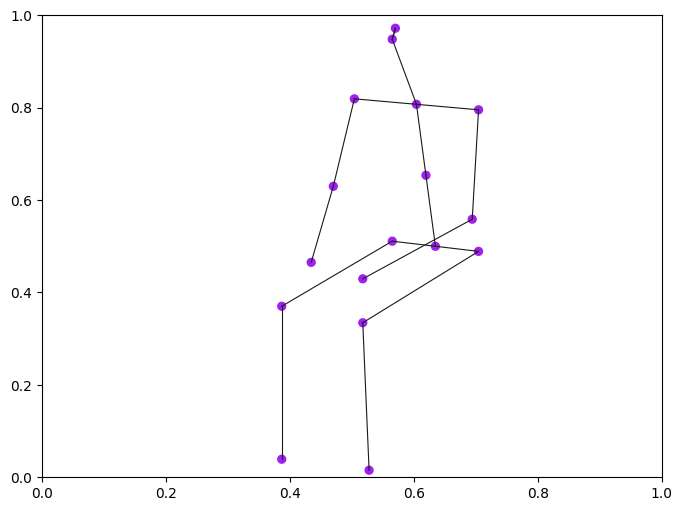

head:  0.521979561202286


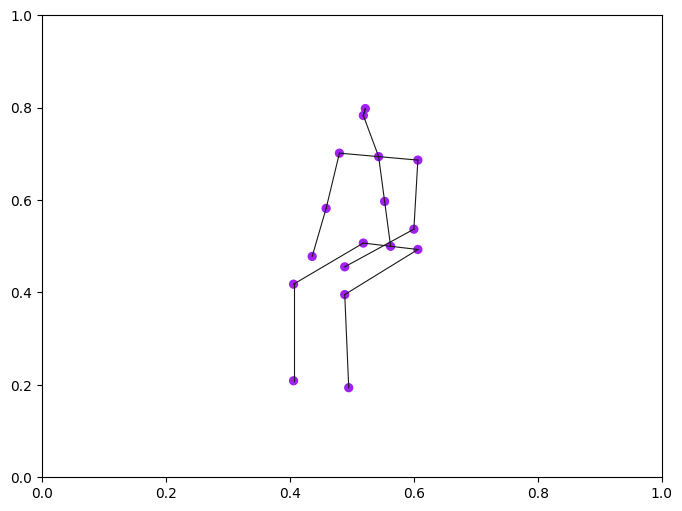

In [34]:

#ann_hrnet = x["annotations"][-1200]
skeleton_hrnet = preprocess_data(ann_hrnet, 120, False, noise = False, scale_range=[1,3])
show_skeleton(skeleton_hrnet)

#ann_pifpaf = x_pifpaf["annotations"][-1200]
skeleton_pifpaf = preprocess_data(ann_pifpaf, 120, False, noise = False, scale_range=[1,3])
show_skeleton(skeleton_pifpaf)

In [243]:
(ann_hrnet["keypoint"][0,0,10,0])

1048.0

In [244]:
(ann_pifpaf["keypoint"][0,0,10,0])

1048.0

In [241]:
ann_pifpaf["keypoint"][:,:,:,0] -= (ann_pifpaf["keypoint"][:,:,:,0] - ann_hrnet["keypoint"][:,:,:,0])

In [112]:
print(np.mean(skeleton_hrnet))

print(np.mean(skeleton_pifpaf))

0.14989116756405887
0.22568978783577304


In [25]:
np.min(ann_hrnet['keypoint'][:,:,:,0])

947.5

In [26]:
np.min(ann_pifpaf['keypoint'][:,:,:,0])#ann_pifpaf['keypoint'][0][0]#.astype(np.float16)

768.0

In [185]:

np.unique(ann_pifpaf['keypoint'][:,:,:,0] == 540.0)



array([False,  True])

In [52]:
print(np.min(ann_hrnet['keypoint']), np.max(ann_hrnet['keypoint']))
print(np.min(ann_pifpaf['keypoint']), np.max(ann_pifpaf['keypoint']))

412.0 1100.0
424.5 1262.0


In [195]:

motion = make_cam(x=ann_hrnet['keypoint'], img_shape=ann_hrnet['img_shape'])
print(motion.shape)
print(np.unique(motion[:,:,:,1]))



(1, 82, 17, 2)
[-0.6619792  -0.6617187  -0.659375   -0.6585938  -0.65729165 -0.65703124
 -0.6567708  -0.6546875  -0.65442705 -0.6541667  -0.6539062  -0.6528646
 -0.65260416 -0.65234375 -0.65208334 -0.6518229  -0.65026045 -0.6497396
 -0.64947915 -0.6481771  -0.6479167  -0.64765626 -0.64739585 -0.6471354
 -0.6453125  -0.6450521  -0.6432291  -0.6408854  -0.640625   -0.6403646
 -0.6390625  -0.63880205 -0.6385417  -0.6377604  -0.6359375  -0.6049479
 -0.6044271  -0.603125   -0.6028646  -0.60234374 -0.6018229  -0.6013021
 -0.6010417  -0.60052085 -0.6002604  -0.6        -0.5994792  -0.5986979
 -0.5981771  -0.59791666 -0.59765625 -0.5971354  -0.596875   -0.5966146
 -0.5958333  -0.5953125  -0.5950521  -0.5942708  -0.59375    -0.5932292
 -0.5546875  -0.55390626 -0.5533854  -0.5502604  -0.5494791  -0.54869795
 -0.5481771  -0.5473958  -0.5471354  -0.5463542  -0.54583335 -0.54505205
 -0.5445312  -0.5442709  -0.54375    -0.5424479  -0.5411458  -0.540625
 -0.5403646  -0.53984374 -0.5390625  -0.5380208

In [198]:
motion = make_cam(x=ann_pifpaf['keypoint'], img_shape=ann_pifpaf['img_shape'])

motion[:,:,:,0][motion[:,:,:,0]<0] = np.mean(motion[:,:,:,0])
motion[:,:,:,1][motion[:,:,:,1]<-0.99] = np.mean(motion[:,:,:,1])

print(np.unique(motion[:,:,:,1]))

[-0.6591948  -0.6590077  -0.65868694 ... -0.2745301  -0.27451575
 -0.27426106]


In [61]:
ann_pifpaf['keypoint'].shape

(1, 82, 17, 2)

In [62]:
print(np.min(ann_hrnet['keypoint']), np.max(ann_pifpaf['keypoint']))

324.5 1099.0


In [5]:
import numpy as np

def fake(motion):
    if motion.shape[0]==1:                                  # Single person, make a fake zero person
        fake = np.zeros(motion.shape)
        motion = np.concatenate((motion, fake), axis=0)
    
    return motion

for item_hrnet, item_pifpaf in zip (x["annotations"], x_pifpaf["annotations"]):

    resample_id = resample(ori_len=item_pifpaf['total_frames'], target_len=243, randomness=False)
    #item_hrnet = resample(ori_len=item_hrnet['total_frames'], target_len=243, randomness=False)

    item_pifpaf["keypoint"] = item_pifpaf["keypoint"][:,resample_id]
    item_hrnet["keypoint"] = item_hrnet["keypoint"][:,resample_id]


    if item_pifpaf["keypoint"].shape[0]==1 and item_hrnet["keypoint"].shape[0]==2:                                  # Single person, make a fake zero person
        item_pifpaf["keypoint"] =fake(item_pifpaf["keypoint"])
        item_pifpaf["keypoint_score"] =fake(item_pifpaf["keypoint_score"])

    #item_pifpaf["keypoint"] =fake(item_pifpaf["keypoint"])
    #item_hrnet["keypoint"] =fake(item_hrnet["keypoint"])

    item_pifpaf["keypoint"][:,:,:,0] -= (item_pifpaf["keypoint"][:,:,:,0] - item_hrnet["keypoint"][:,:,:,0])
    #ann_pifpaf["keypoint"][:,:,:,1] -= (ann_pifpaf["keypoint"][:,:,:,1] - ann_hrnet["keypoint"][:,:,:,1])

    #item_pifpaf["keypoint"][item_pifpaf["keypoint"]<1] = item_pifpaf["img_shape"][0] //2
    #print (np.min(item_hrnet["keypoint"]), np.min(item_pifpaf["keypoint"]))
    #diff_x = np.mean(item_pifpaf["keypoint"][:,:,:,0]) - np.mean(item_hrnet["keypoint"][:,:,:,0])
    #diff_y = np.mean(item_pifpaf["keypoint"][:,:,:,1]) - np.mean(item_hrnet["keypoint"][:,:,:,1])

    """ item_pifpaf["keypoint"][:,:,:,0] = (item_pifpaf["keypoint"][:,:,:,0] - np.mean(item_hrnet["keypoint"][:,:,:,0])) / np.std(item_hrnet["keypoint"][:,:,:,0])
    item_pifpaf["keypoint"][:,:,:,1] = (item_pifpaf["keypoint"][:,:,:,1] - np.mean(item_hrnet["keypoint"][:,:,:,1])) / np.std(item_hrnet["keypoint"][:,:,:,1])
    
    diff = abs(np.mean(item_pifpaf["keypoint"]) - np.mean(item_hrnet["keypoint"]))

    print(diff)

    if diff > 100:
        print (item_hrnet["keypoint"].shape, item_pifpaf["keypoint"].shape)
        print(item_hrnet["frame_dir"], item_pifpaf["frame_dir"])
        break """

In [2]:
x["annotations"][0]["keypoint_score"]

array([[[0.934 , 0.9766, 0.9736, ..., 0.876 , 0.8857, 0.892 ],
        [0.9546, 0.993 , 0.989 , ..., 0.877 , 0.9043, 0.9014],
        [0.9536, 0.9937, 0.988 , ..., 0.8867, 0.907 , 0.903 ],
        ...,
        [0.9365, 0.9043, 0.9414, ..., 0.8955, 0.888 , 0.9033],
        [0.9585, 0.9385, 0.939 , ..., 0.8984, 0.9126, 0.9146],
        [0.9395, 0.904 , 0.9453, ..., 0.898 , 0.8813, 0.886 ]]],
      dtype=float16)

In [5]:
import numpy as np
x_pifpaf["annotations"][0]["keypoint_score"].astype(np.float16)

array([[[0.999 , 0.992 , 0.9937, ..., 0.8433, 0.9385, 0.788 ],
        [0.999 , 0.991 , 0.993 , ..., 0.8945, 0.9473, 0.8506],
        [0.999 , 0.991 , 0.9937, ..., 0.8823, 0.9375, 0.818 ],
        ...,
        [0.913 , 0.9917, 0.9214, ..., 0.9106, 0.9165, 0.879 ],
        [0.908 , 0.9917, 0.893 , ..., 0.884 , 0.8413, 0.8486],
        [0.9014, 0.991 , 0.925 , ..., 0.746 , 0.867 , 0.793 ]]],
      dtype=float16)

In [3]:
with open('datasets/ntu60/Frames/ntu60_openpifpaf_HQ_fixed5.pkl', 'rb') as f:
    x_pifpaf = pickle.load(f)

In [5]:
for pifpaf_ann in x_pifpaf["annotations"]:

    if pifpaf_ann["keypoint"].shape[1]!=pifpaf_ann["keypoint_score"].shape[1]:                                  # Single person, make a fake zero person
        
        print(pifpaf_ann["keypoint"].shape, pifpaf_ann["keypoint_score"].shape)